In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [50]:
iris = load_iris()

data = np.column_stack([iris['data'], iris['target'] == 0, iris['target'] == 1, iris['target'] == 2 ])

# Initially we will make a prediction using only 2 columns
data = np.column_stack([data[:,0], data[:,2], data[:,-3:]])
data[:5]

array([[5.1, 1.4, 1. , 0. , 0. ],
       [4.9, 1.4, 1. , 0. , 0. ],
       [4.7, 1.3, 1. , 0. , 0. ],
       [4.6, 1.5, 1. , 0. , 0. ],
       [5. , 1.4, 1. , 0. , 0. ]])

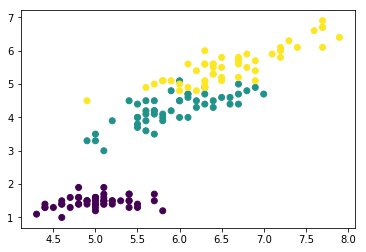

In [51]:
# Let's plot the 2 columns
plt.scatter(data[:,0], data[:,1], c=iris['target'])

In [103]:
f  = np.vectorize(lambda x: 1 / (1 + np.exp(-x)))
df = np.vectorize(lambda x: f(x) * (1 - f(x)))

# Calculates net()
net = lambda w, x, theta: w.dot(x) + theta

class MLP:
    def __init__(self, inputLength=2, hiddenLength=3, outputLength=3):
        self.inputLength = inputLength
        self.hiddenLength = hiddenLength
        self.outputLength = outputLength
        
        # Theta vector
        self.hiddenTheta = np.random.uniform(low=-0.5, high=0.5, size=hiddenLength)
        self.outputTheta = np.random.uniform(low=-0.5, high=0.5, size=outputLength)
        
        # Weights arrays
        self.hiddenWeight = np.random.uniform(
                low=-0.5, high=0.5, size=inputLength*hiddenLength
            ).reshape(hiddenLength, inputLength)
        self.outputWeight = np.random.uniform(
                low=-0.5, high=0.5, size=hiddenLength*outputLength
            ).reshape(outputLength, hiddenLength)

    def forward(self, query):
        # First we calculate f(net) of the hidden layer
        hiddenFNet = np.zeros(self.hiddenLength)
        for i in range(self.hiddenLength):
            hiddenFNet[i] = f(net(self.hiddenWeight[i], query, self.hiddenTheta[i]))
        
        # Then we calculate net of the output layer
        outputFNet = np.zeros(self.outputLength)
        for i in range(self.outputLength):
            outputFNet[i] = f(net(self.outputWeight[i], hiddenFNet, self.outputTheta[i]))
        
        return outputFNet
    
    def _train(self, inp, out, eta):
        # Since we'll use f(net) and df(net) plenty of times, we calculate it already
        hiddenFNet = np.zeros(self.hiddenLength)
        hiddenDFNet = np.zeros(self.hiddenLength)
        for i in range(self.hiddenLength):
            n = net(self.hiddenWeight[i], inp, self.hiddenTheta[i])
            hiddenFNet[i] = f(n)
            hiddenDFNet[i] = df(n)
        
        outputFNet = np.zeros(self.outputLength)
        outputDFNet = np.zeros(self.outputLength)
        for i in range(self.outputLength):
            n = net(self.outputWeight[i], hiddenFNet, self.outputTheta[i])
            outputFNet[i] = f(n)
            outputDFNet[i] = df(n)
        
        # Update output layer weights
        for k in range(self.outputLength):
            for j in range(self.hiddenLength):
                self.outputWeight[k][j] = \
                    self.outputWeight[k][j] - eta * \
                    (-2 * (out[k] - outputFNet[k]) * outputDFNet[k] * hiddenFNet[j])
        
        # Update output layer thetas
        for k in range(self.outputLength):
            self.outputTheta[k] = \
                self.outputTheta[k] - eta * \
                (-2 * (out[k] - outputFNet[k]) * outputDFNet[k])
        
        # Update hidden layer weights together with thetas (cuz of data dependence).        
        for j in range(self.hiddenLength):
            for i in range(self.inputLength):
                sigma = np.sum([
                    (out[k] - outputFNet[k]) * \
                    outputDFNet[k] * \
                    self.outputWeight[k][j] \
                    for k in range(self.outputLength)
                ])
                
                self.hiddenWeight[j][i] = \
                    self.hiddenWeight[j][i] - eta * \
                    (-2 * hiddenDFNet[j] * inp[i] * sigma)
                    
                self.hiddenTheta[j] = \
                    self.hiddenTheta[j] - eta * \
                    (-2 * hiddenDFNet[j] * sigma)
    
    def backward(self, dataset, eta=0.5, maxIter=10**2, threshold=1e-5):
        if len(dataset[0]) != self.inputLength + self.outputLength:
            print("Dataset does not comply with defined MLP architecture.")
            return
        
        for i in range(maxIter):
            print("Iteration: ", i);
            squared_error = 0
            
            for row in dataset:
                inp = row[:self.inputLength]
                out = row[self.inputLength:]
                
                squared_error += np.sum(out - self.forward(inp))**2
                self._train(inp, out, eta)
            
            squared_error /= dataset.shape[0]
            print("Error: ", squared_error)
            if(squared_error <= threshold):
                print("Convergence reached.")
                return
        
        print("Max iterations reached.")


In [104]:
# Normalize the data
d = data[:,0]
data[:,0] = (d - min(d)) / (max(d) - min(d))

d = data[:,1]
data[:,1] = (d - min(d)) / (max(d) - min(d))

In [105]:
mlp = MLP()

mlp.backward(data, maxIter=10, threshold=1e-4, eta=0.2)

Iteration:  0
Error:  0.021506517232465803
Iteration:  1
Error:  0.0036772794291688687
Iteration:  2
Error:  0.004325580056291689
Iteration:  3
Error:  0.0050316144216910295
Iteration:  4
Error:  0.005940570276495197
Iteration:  5
Error:  0.006922805952954449
Iteration:  6
Error:  0.008077566100551544
Iteration:  7
Error:  0.009647019253680236
Iteration:  8
Error:  0.01157059368979535
Iteration:  9
Error:  0.013553834109050991
Max iterations reached.


In [106]:
err = 0
for i in range(data.shape[0]//10):
    print(data[i*10], mlp.forward(data[N][:2]))

[0.22222222 0.06779661 1.         0.         0.        ] [0.03255318 0.11953653 0.89568024]
[0.30555556 0.08474576 1.         0.         0.        ] [0.03255318 0.11953653 0.89568024]
[0.30555556 0.11864407 1.         0.         0.        ] [0.03255318 0.11953653 0.89568024]
[0.13888889 0.10169492 1.         0.         0.        ] [0.03255318 0.11953653 0.89568024]
[0.19444444 0.05084746 1.         0.         0.        ] [0.03255318 0.11953653 0.89568024]
[0.75       0.62711864 0.         1.         0.        ] [0.03255318 0.11953653 0.89568024]
[0.19444444 0.42372881 0.         1.         0.        ] [0.03255318 0.11953653 0.89568024]
[0.44444444 0.6440678  0.         1.         0.        ] [0.03255318 0.11953653 0.89568024]
[0.33333333 0.47457627 0.         1.         0.        ] [0.03255318 0.11953653 0.89568024]
[0.33333333 0.57627119 0.         1.         0.        ] [0.03255318 0.11953653 0.89568024]
[0.55555556 0.84745763 0.         0.         1.        ] [0.03255318 0.11953653 